# Face Recognition using LDA

In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import glob
import random
import re

I have used the orl dataset. Considering fifteen different people each having 10 photos in the dataset. I have used 5 photos for training and the remaining 5 photos for testing purpose. Here in the function get_filenames all the file locations of train and test images will be returned so that they can be loaded later easily.

In [2]:
def get_filenames(X, train=True):
    img_locations = []
    for i in range(15):
        for j in range(X):
            if(train):
                img_locations.append("images/s{}/{}.pgm".format(i+1, j+1))
            else:
                img_locations.append("images/s{}/{}.pgm".format(i+1, j+10-X+1))
    return img_locations

Given the locations of images as input this below funtion generates the train and test data with their corresponding labels.

In [3]:
def load_data(img_locs):
    X, Y = [], []
    for loc in img_locs:
        img = np.array(Image.open(loc)).flatten()
        label = re.findall("[0-9]+/",loc)[0]
        label = int(label[:-1])
        X.append(img), Y.append(label)
    return np.array(X), np.array(Y)

The below view data function is used to display the images used for training and testing.

In [4]:
def view_data(imgs, w, h):
    x = len(imgs)/ 5
    count = 1
    for img in imgs:
        i = img.reshape(w, h)
        plt.subplot(x, 5, count)
        plt.imshow(i, cmap='gray')
        plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
        plt.subplots_adjust(right=1.2, top=2.5)
        count += 1
        
    plt.show()

The below model has all the functions related to PCA train, test algos followed by LDA train, test algos.

In [5]:
class Model:
    
    def get_mean(self, imgs):
        return np.mean(imgs, axis=0)
    
    def train_lda(self, classes, signature, split, K):
        M = np.mean(signature, axis=1)
        # print(M)
        mus = []
        for i in range(0, len(classes), split):
            mus.append(np.mean(signature.T[i:i+split - 1], axis=0))
        mus = np.array(mus)
        SW = np.zeros((K, K))
        # print(SW)
        for i in range(0, len(classes), split):
            V = signature.T[i:i+split-1]
            T = V -mus[int(i/5)]
            sigma = T.T.dot(T)
            SW += sigma
        # print(SW)
        SB = np.zeros((K, K))
        for i in range(len(mus)):
            sigma = (mus[i] - M).dot(mus[i].T)
            SB += sigma

        J = np.linalg.inv(SW).dot(SB)

        w, v = np.linalg.eig(J)
        p = w.argsort()[::-1]

        sorted = v[w.argsort()[::-1]]
        W = sorted[:10].T
        # print(W.shape)

        FF = W.T.dot(signature)

        return FF, W
    
    def test_lda(self, image, FF, W, signature, phi):
        image = image - self.mean
        PEF = phi.dot(image)
        Projected_Fisher_Test_Image = W.T.dot(PEF)
        dists = []
        for i in range(FF.shape[1]):
            dist = np.linalg.norm(Projected_Fisher_Test_Image-FF[:,i])
            dists.append(dist)
        dists = np.array(dists)
        min_ind = np.argmin(dists)
        return self.Y[min_ind]

    def train_pca(self, imgs, classes, K):
        self.mean = self.get_mean(imgs)
        self.Y = classes
        imgs = imgs - self.mean
        C = np.cov(imgs)
        w, v = np.linalg.eig(C)

        p = w.argsort()[::-1]
        # print(p)
        sorted = v[w.argsort()[::-1]]
        shi = sorted[:K].T
        phi = shi.T.dot(imgs)
        signature = phi.dot(imgs.T)
        return phi, signature

    def test_pca(self, image, signature, phi):
        image = image - self.mean
        # print(image.shape)
        sigma = phi.dot(image)
        dists = []
        for i in range(signature.shape[1]):
            dist = np.linalg.norm(sigma-signature[:,i])
            dists.append(dist)
        dists = np.array(dists)
        min_ind = np.argmin(dists)
        return self.Y[min_ind]

The below function calculates the accuracy

In [6]:
def calculate_acc(YY, test_y):
    count = 0
    correct = 0
    wrong = 0
    for i in range(len(YY)):
        if(YY[i] == test_y[i]):
            correct += 1
        else:
            wrong += 1
            
        count += 1
    
    acc = correct / count
    return acc, correct, count
    

Train images


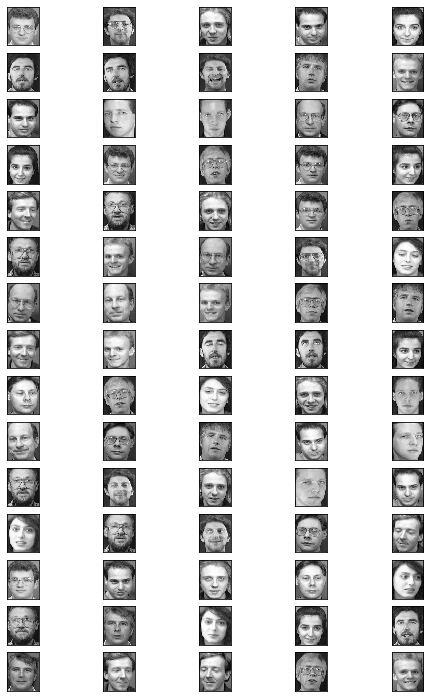

Test images


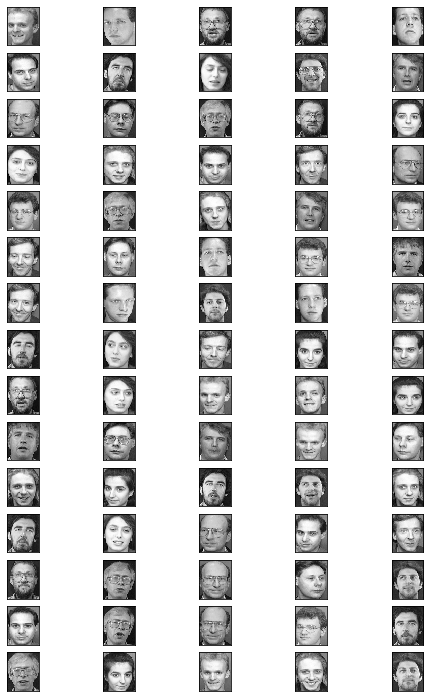

In [7]:
train_img_loc = get_filenames(5)
test_imag_loc = get_filenames(5, train=False)

random.shuffle(train_img_loc)
random.shuffle(test_imag_loc)

w, h = np.array(Image.open(train_img_loc[0])).shape

train_imgs, train_classes = load_data(train_img_loc)
test_imgs, test_classes = load_data(test_imag_loc)

print("Train images")
view_data(train_imgs, w, h)

print("Test images")
view_data(test_imgs, w, h)

Mean Face


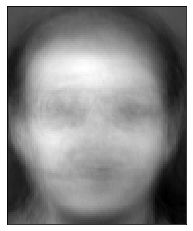

TRAINING...done 

Accuracy using LDA: 0.84
Accuracy using PCA: 0.9066666666666666

TESTING...done



In [8]:
model = Model()
print("Mean Face")
mean = model.get_mean(train_imgs)
plt.imshow(mean.reshape(w,h), cmap='gray')
plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
plt.show()

# Number of components 
k = 10

# PCA TRAIN
phi , signature = model.train_pca(train_imgs, train_classes, k)

# LDA TRAIN
FF , W = model.train_lda(train_classes, signature, 5, k)
print("TRAINING...done ")

# LDA TEST
count = 0
preds = []
for i in range(len(test_imgs)):
    out = model.test_lda(test_imgs[i], FF, W, signature, phi)
    preds.append(out)

acc, correct, count = calculate_acc(preds, test_classes)
print("\nAccuracy using LDA: {}".format(acc))


# PCA TEST
preds = []
for i in range(len(test_imgs)):
    out = model.test_pca(test_imgs[i], signature, phi)
    preds.append(out)

acc, correct, count = calculate_acc(preds, test_classes)
print("Accuracy using PCA: {}".format(acc))
print("\nTESTING...done")
print()